# LowCarb thorax disease classification in Flower

This notebook follows adapts the official "Introduction to Federated Learning" from the Flower tutorial using PyTorch and the CIFAR10 dataset, to a real life Federated Learning scenario. Here, we simulate the decentralized model training of hospitals on a thorax disease classification problem.

## 1. Install packages

In [ ]:
# First we install the Flwr package
!pip install -q flwr[simulation]

In [ ]:
# Next, we install our Lowcarb, powered by the carbon-aware SDK to enable carbon-aware Federated Learning!
!pip install flwr-lowcarb

## 2. Imports

In [ ]:
import os
import sys
import math
import time
from glob import glob
from PIL import Image
from random import sample
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nnqunt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms as T, models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda:0


## 3. Prepare the data

### Download the data and prepare directories

In [ ]:
# Download & Unzip data.zip, create data set directory, needs to be done using kaggle, etc.
!mkdir NIH
# In order for this command to work, make sure your api token "kaggle.json" resides in /root/.kaggle/
#!kaggle datasets download -d nih-chest-xrays/data
!cp '/content/drive/MyDrive/carbonhack22/data.zip' '/content/'
!unzip -q '/content/data.zip' -d '/content/NIH/'
!rm '/content/data.zip'

### Main utility function for the used data set

In [ ]:
from PIL import Image
from itertools import chain

import numpy as np
import pandas as pd

from torch.utils.data import Dataset

class NIH_Dataset(Dataset):
  """
  Main Dataset class to represent NIH Chest X-Ray data
  ...
  Attributes
  ----------
  data_df: pandas.DataFrame
    A DataFrame that needs to at least have the following two columns:
      1. "path": Holds chest x-ray image locations
      2. "disease_vec": Holds multilabel one-hot encoded vector
  transform: torchvision.transform.Compose
    Image transformations that will be applied to each image when calling "__getitem__"
  """
  def __init__(
    self, 
    data_df,
    transform=None
    ) -> Dataset:
    """
    Parameters
    ----------
    data_df: pandas.DataFrame
      A DataFrame that needs to at least have the following two columns: 
        1. "path": Holds chest x-ray image locations
        2. "disease_vec": Holds multilabel one-hot encoded vector
    transform: torchvision.transform.Compose
      Image transformations that will be applied to each image when calling "__getitem__"
    """
    self.data_df = data_df
    self.transform = transform 

  def __len__(
    self
    ) -> int:
    return len(self.data_df)

  def __getitem__(
    self, 
    idx
    ) -> Tuple[torch.Tensor, np.ndarray]:
    img_file = self.data_df['path'].iloc[idx]
    img = Image.open(img_file).convert('RGB')
    label = np.array(self.data_df.iloc[:,-1].iloc[idx], dtype=float)
    if self.transform:
        img = self.transform(img)

    return img, label

In [ ]:
def load_and_preprocess_data_df(
    data_df_root_path: str,
    num_data_samples: int = 11000
    ) -> Tuple[pd.DataFrame, List]:
  """
  Loads and preprocesses NIH DataFrame that holds information of the data, e.g. image labels.

  Parameters
  ----------
  data_df_root_path: str
    This should be the path to the root directory of the NIH data set that, 
    at least, includes the img-file directories and the panda.DataFrame 
    "Data_Entry_2017.csv". The direcotry should have the following structure:

    NIH
      |
      images_0**
      ...
      Data_Entry_2017.csv
      ...
      train_val_list.txt

  num_data_samples: int
    The total number of data points that we want to sample for our data set.
    Maximum is 112120.
  
  Returns
  -------
  preprocessed_xray_df: pd.DataFrame
    Preprocessed pandas DataFrame with column "path"

  all_labels: List
    List containing all labels as strings
  """
  # Load the DataFrame
  all_xray_df = pd.read_csv(
      os.path.join(
          data_df_root_path,
          'Data_Entry_2017.csv'
          )
      )
  # Extract all image paths
  all_image_paths = {
      os.path.basename(x): x for x in 
      glob(os.path.join(data_df_root_path, 'images*', '*', '*.png'))
      }
  # Add image file name column
  all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
  # Count labels
  all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))  
  all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
  all_labels = [x for x in all_labels if len(x)>0]
  for c_label in all_labels:
      if len(c_label)>1: # leave out empty labels
          all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
  MIN_CASES = 1000
  all_labels = [
      c_label for c_label in all_labels if all_xray_df[c_label].sum() > MIN_CASES
      ]
  sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
  sample_weights /= sample_weights.sum()
  preprocessed_xray_df = all_xray_df.sample(num_data_samples, weights=sample_weights)
  # Create one-hot encoding of the vector
  preprocessed_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
  
  return preprocessed_xray_df, all_labels

In [ ]:
def inv_data_transform(
    img: torch.Tensor
    ) -> torch.Tensor:
  """
  Helper function that un-normalizes torch image tensor
  """
  img = img.permute(1,2,0)
  img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
  return img

def get_data_loaders(
    data_df_root_path: str,
    num_data_samples: int = 11000,
    global_train_frac: float = 0.8,
    local_train_frac: float = 0.8,
    batch_size: int = 32,
    num_clients: int = 10
    ) -> Tuple[Tuple[DataLoader, ...], Tuple[DataLoader, ...], DataLoader, List]:

  """
  Main function to create DataLoaders of the NIH X-Ray data set.
  
  Parameters
  ----------
  data_df_root_path: str
    This should be the path to the root directory of the NIH data set that, 
    at least, includes the img-file directories and the panda.DataFrame 
    "Data_Entry_2017.csv". The direcotry should have the following structure:
    NIHs
      |
      images_0**
      ...
      Data_Entry_2017.csv
      ...
      train_val_list.txt

  num_data_samples: int
    The total number of data points that we want to sample for our data set.
    Maximum is 112120.

  global_train_frac: float
    The fraction of points used for the global training data set, e.g. the data set that will be later split into local client data sets.

  local_train_frac: float
      The fraction of points on each local client used for training.

  batch_size: int
    Batch size on each client

  num_clients: int
    Total number of clients in the FL setup

  Returns
  -------
  trainloaders: List[torch.utils.data.DataLoader, ...]
    List of local training DataLoaders, one for each client

  valloaders: List[torch.utils.data.DataLoader, ...]
    List of local calidation DataLoaders, one for each client

  testloader: torch.utils.data.DataLoader
    Global test DataLoader, for the central server
  
  all_labels: List[str, ...]
    List of all string labels

  preprocessed_data_df: pd.DataFrame
    preprocessed Dataframe that represents the data
  """
  
  preprocessed_xray_df, all_labels = load_and_preprocess_data_df(
      data_df_root_path,
      num_data_samples
  )

  train_data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])

  test_data_transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])
  
  train_df, test_df = train_test_split(
      preprocessed_xray_df,
      test_size = 1 - global_train_frac,
      random_state = 42,
      stratify = preprocessed_xray_df['Finding Labels'].map( lambda x: x[:4])
  )

  trainset = NIH_Dataset(
      train_df,
      transform = train_data_transform
      )
  
  testset = NIH_Dataset(
      test_df,
      transform = test_data_transform
      )

  # Split training set into `num_clients` partitions to simulate different local datasets
  partition_size = len(trainset) // num_clients
  lengths = [partition_size] * num_clients
  lengths[-1] += len(trainset) - np.sum(lengths)
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:      
      len_train = math.ceil(len(ds) * local_train_frac)
      len_val = len(ds) - math.ceil(len(ds) * local_train_frac)
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last = True))
      valloaders.append(DataLoader(ds_val, batch_size=batch_size, drop_last = True))
  testloader = DataLoader(testset, batch_size=batch_size)

  return trainloaders, valloaders, testloader, all_labels, preprocessed_xray_df

### Load the data

In [ ]:
num_clients = 100

data_df_root_path = '/content/NIH/'
num_data_samples = 112120
global_train_frac = 0.95
local_train_frac = 0.9
batch_size = 32

trainloaders, valloaders, testloader, all_labels, preprocessed_xray_df = get_data_loaders(
    data_df_root_path = data_df_root_path,
    num_clients = num_clients,
    num_data_samples = num_data_samples,
    global_train_frac = global_train_frac,
    local_train_frac = local_train_frac,
    batch_size = batch_size
)

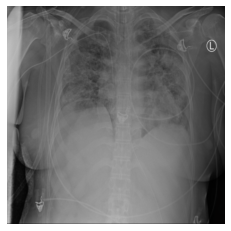

In [ ]:
plt.imshow(
    inv_data_transform(
        testloader.dataset[0][0]
    )
)
plt.axis('off');

In [ ]:
len(trainloaders[0].dataset), len(valloaders[0].dataset) ,len(testloader.dataset), len(all_labels)

(959, 106, 5607, 13)

## 4. Training

### Train and test utils
Here, we implement the main training util functions that we need for the multilabel, classification problem.

In [ ]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon = 1e-7):
    y_pred = torch.sigmoid(y_pred)
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

def get_acc_data(
    class_names,
    acc_list
    ):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Class Acc.']) 
    return df

### Client train and test function used in Flower training setup

In [ ]:
def train(
    net,
    trainloader,
    epochs
    ):
    print(f'Entered train function, total num. of epochs: {epochs}')
    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    valid_loss_min = np.Inf
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = 1e-4
        )
    start_time = time.time()
    for i in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 
        net.train()
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            ps = net(images)
            
            loss = weighted_loss(pos_weights, neg_weights, ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)
        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    end_time = time.time()
    time_delta = end_time - start_time
    print('\n')
    print(f'Time to complete local training round: {time_delta}')
    print('\n')

def test(net, testloader):
    
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    per_class_accuracy = [0 for i in range(len(all_labels))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset)) * 100.0 for i in per_class_accuracy]

    return loss, np.mean(per_class_accuracy)

### Server evaluation function used in Flower training setup

In [ ]:
def server_eval(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar]
    ):

    freq_pos, freq_neg = compute_class_freqs(preprocessed_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos
    net = init_net().to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    per_class_accuracy = [0 for i in range(len(all_labels))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            ps = torch.sigmoid(ps)
            ps = (ps >= 0.5).float()
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)
            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())
        per_class_accuracy = [(i/len(testloader.dataset))*100.0 for i in per_class_accuracy]
    test_df = get_acc_data(all_labels, per_class_accuracy)
    print('\nServer eval')
    print(test_df)
    print('\n')

    return loss,  {"mean_class_acc.": np.mean(per_class_accuracy)}

### Implementation of the Flower Client
The FlowerClient for this demo is based on the Flower tutorial.

Besides this, granting your client Carbon-Awareness is as non-invasive as it gets.

To make your client implementation compatible with lowcarb's LowcarbClientManager (which we'll meet further down the line), you have to make sure only one thing: its get_properties() must return a dict that contains the client's location as a str, e.g. 'uksouth', 'westeurope', 'westus'

class Carbon_Aware_Client():
    def __init__(self, location: str):
        self.location = location

    # Make sure the get_properties() method returns the client's location inside a dict
    def get_properties(self, config) -> dict:
        return {'location': self.location}
That's it.

Note: If the client's location changes throughout its lifetime, just update it dynamically in get_properties(). The LowcarbClientManager queries it each round.

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, location: str, *args, **kwargs):
        super(FlowerClient, self).__init__(*args, **kwargs)
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

        ### Giving the client a location upon instantiation
        self.location = location

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        epochs = config["local_epochs"]
        train(self.net, self.trainloader, epochs=epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

    # Make sure the get_properties() method returns the client's location inside a dict
    def get_properties(self, config) -> dict:
        return {'location': self.location}

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    try:
      net.load_state_dict(state_dict, strict=True)
    except:
      print('Skip loading params')

### Flower Simulation Setup
Generating Clients at Locations around the World
For performance reasons, the clients are not persistent and are instantiated (NUM_CLIENTS in total) each round by the simulation calling client_generator(cid: str) with ['01', '02', '03', ...] (see the Flower tutorial). Thus, we sample the clients-location-mapping client_regions_by_cid from a list of available regions available_regions, which are supported by the Carbon-Aware-SDK. Important: the mapping has to be done outside the scope of client_generator.

IMPORTANT: this is not the carbon-aware sampling for each federated learning round. The client_generator only creates the pool of available clients (from which the LowcarbClientManager will sample clients in a carbon-aware manner later).

In [ ]:
def init_net():  
  net = models.resnet18(
    weights=None
  )
  net.fc = torch.nn.Linear(
      net.fc.in_features,
      len(all_labels)
  )
  return net

available_regions = ['westcentralus', 'ukwest', 'uksouth', 'westeurope', 
                     'westus', 'australiacentral', 'australiaeast', 
                     'swedencentral', 'norwaywest', 'norwayeast', 'northeurope', 
                     'centralus', 'francesouth', 'francecentral']

client_regions_by_cid = [sample(available_regions, 1)[0] for i in range(0, num_clients)]

def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    net = init_net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    print(f'Created client: {cid}')
    return FlowerClient(net, trainloader, valloader, location=client_regions_by_cid[int(cid)])

### Using the default SimpleClientManager
Flower's defautl SimpleClientManager *randomly* selects participating clients in each communication round.

#### Starting the Simulation

In [ ]:
num_rounds = 100
local_epochs = 35 # On an A100, 35 local epochs should take approximately 15 mins
fraction_fit = 0.03
fraction_evaluate = 0.03
min_fit_clients = 3
min_evaluate_clients = 3

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
history_simple_client_manager = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

### Using the LowcarbClientManager
For your Flower application to become carbon-aware and automatically select only clients with the least possible carbon footprint, use the LowcarbClientManager. LowcarbClientManager is powered by the Carbon-Aware-SDK's WebApi. Feel free to host it locally or use a remote endpoint.

In [ ]:
from lowcarb.lowcarb_client_manager import LowcarbClientManager

carbon_aware_sdk_api = 'https://carbon-aware-api.azurewebsites.net' # URL to the Carbon-Aware_SDK's WebApi
workload_duration = 15  # estimated workload of each training in minutes
forecast_window = 12    # forecast window considered by the client manager in hours
lowcarb_client_manager = LowcarbClientManager(api_host=carbon_aware_sdk_api, workload_duration=15, forecast_window=12)

#### Starting the Simulation

In [ ]:
num_rounds = 3
local_epochs = 35 # On an A100, 35 local epochs should take approximately 15 mins
fraction_fit = 0.03
fraction_evaluate = 0.03
min_fit_clients = 3
min_evaluate_clients = 3

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }
def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config
# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())
# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)
# Start simulation
history_lowcarb_client_manager = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_manager=lowcarb_client_manager,  # pass the lowcarb_client_manager to the simulation
    client_resources=client_resources
)